In [317]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [318]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [319]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [320]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

Загрузка датасета

In [321]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/content/prochnost.csv")

# Display the first 3 examples.
dataset_df.head(10)

,D1,D2,MWCNT,P,HV
0,29.213,22.259,0,100,248.427
1,35.240,30.992,0,100,189.264
2,34.086,32.304,0,100,188.798
3,23.802,28.537,0,100,258.566
4,28.826,28.752,0,100,212.741
5,35.240,44.605,0,200,220.361
6,33.154,33.928,0,200,274.604
7,41.658,44.128,0,200,183.300
8,36.322,38.176,0,200,271.739
9,44.823,41.811,0,200,190.430


Функция для разделения датасета на выборку для обучения и выборку для тестирования (в соотношении 70 к 30)

In [322]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

36 examples in training, 15 examples for testing.


Поместить в лэйбл имя предсказываемого параметра

In [323]:
# Name of the label column.
label = "HV"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

Обучение модели на регрессию

In [324]:
%set_cell_height 300

# Configure the model.
model_RF = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,  num_trees=100)

# Train the model.
history = model_RF.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpoajs77pl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.251495. Found 36 examples.
Training model...
Model trained in 0:00:00.028351
Compiling model...
Model compiled.


Сохранение модели

In [325]:
model_RF.save("/tmp/my_saved_model")

Оценка модели по MSE, RMSE, MAE и MAPE

In [326]:
# Evaluate the model on the test dataset.
model_RF.compile(metrics=["mse", "mae", "mape"])
evaluation = model_RF.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print(f"MAE: {evaluation['mae']}")
print(f"MAPE: {evaluation['mape']}")
tfdf.model_plotter.plot_model_in_colab(model_RF, tree_idx=0, max_depth=3)

1/1 [==============================] - 0s 262ms/step - loss: 0.0000e+00 - mse: 601.7629 - mae: 19.4823 - mape: 9.6640
{'loss': 0.0, 'mse': 601.7628784179688, 'mae': 19.48233413696289, 'mape': 9.664027214050293}

MSE: 601.7628784179688
RMSE: 24.53085563974418
MAE: 19.48233413696289
MAPE: 9.664027214050293


Вывод различной информации о модели

In [327]:
%set_cell_height 150
model_RF.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (4):
	D1
	D2
	MWCNT
	P

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  2.740333 ################
    2.       "P"  1.827500 ######
    3.   "MWCNT"  1.694167 #####
    4.      "D1"  1.490500 ###
    5.      "D2"  1.155167 

Variable Importance: NUM_AS_ROOT:
    1.    "D2" 38.000000 ################
    2.    "D1" 31.000000 ############
    3. "MWCNT" 28.000000 ###########
    4.     "P"  3.000000 

Variable Importance: NUM_NODES:
    1.    "D2" 169.000000 ################
    2.    "D1" 127.000000 #########
    3.     "P" 97.000000 ####
    4. "MWCNT" 66.000000 

Variable Importance: SUM_SCORE:
    1.    "D2" 1

In [328]:
%set_cell_height 150
model_RF.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=11, accuracy=None, loss=None, rmse=41.63538704137491, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=36, accuracy=None, loss=None, rmse=45.46456920950468, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=36, accuracy=None, loss=None, rmse=41.5035583640684, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=36, accuracy=None, loss=None, rmse=39.98254379638077, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=36, accuracy=None, loss=None, rmse=39.01153971316479, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=36, accuracy=None, loss=None, rmse=38.342747376017506, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=61, evaluation=Evaluation(n

Визуализация снижения ошибки RMSE

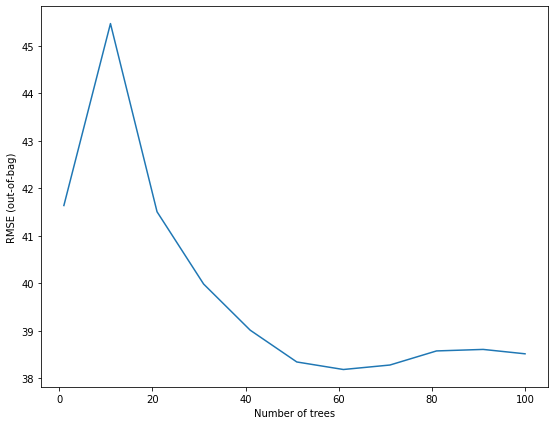

In [329]:
import matplotlib.pyplot as plt

logs = model_RF.make_inspector().training_logs()

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

Предсказание значений с помощью созданной модели

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


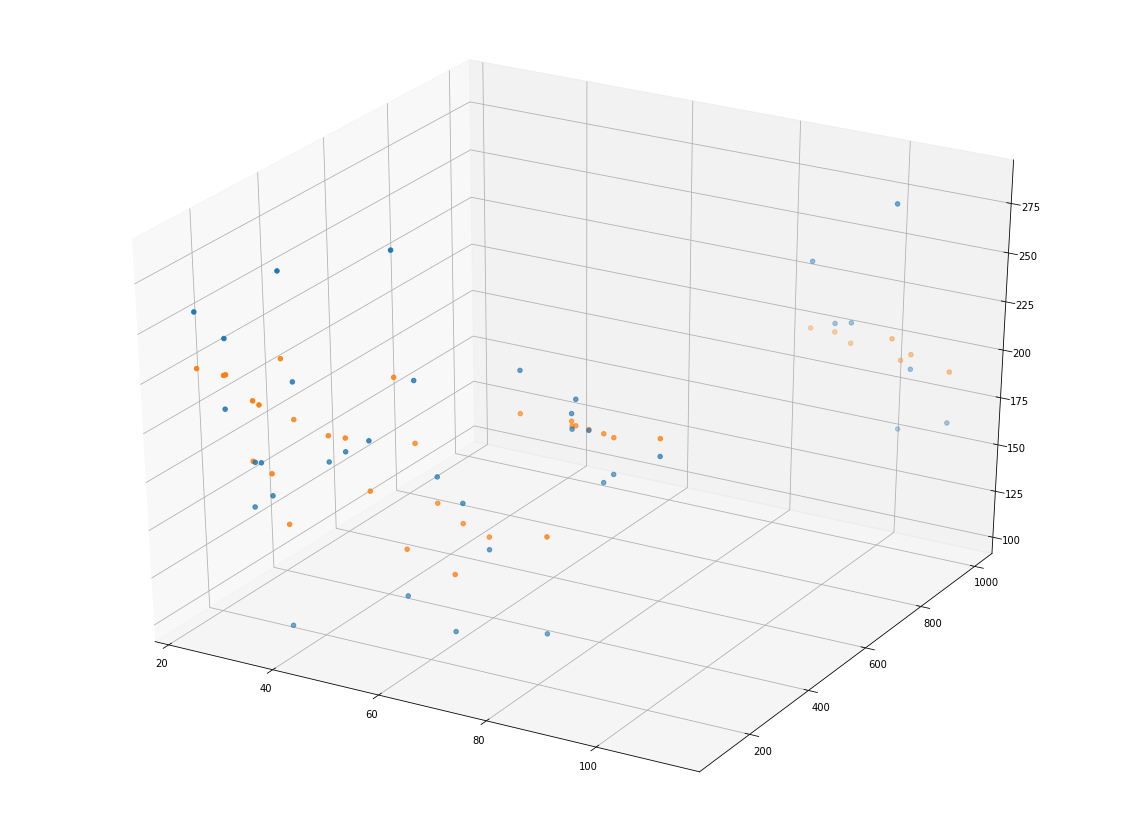

In [331]:
#Предсказанные значения для тестовой выборки
import matplotlib.pyplot as plt
predictions = model_RF.predict(train_ds, verbose=0)
original = train_ds_pd['HV'].to_numpy()
print(type(predictions))
print(type(original))
     
#TODO:
z1 = original
z2 = predictions
x = train_ds_pd['D1'].to_numpy()
y = train_ds_pd['P'].to_numpy()

# plt.scatter(x,z)
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z1)
ax.scatter(x, y, z2)